In [34]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from  tensorflow.keras import losses

In [35]:
tf.__version__

'2.19.0'

### Sentiment Analysis

In [36]:
# Use this if you have not dowloaded locally
'''
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
'''

'\nurl = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"\n\ndataset = tf.keras.utils.get_file("aclImdb_v1", url,\n                                    untar=True, cache_dir=\'.\',\n                                    cache_subdir=\'\')\n\ndataset_dir = os.path.join(os.path.dirname(dataset), \'aclImdb\')\n'

In [37]:
dataset_dir = './aclImdb'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [38]:
os.listdir(train_dir)

['.DS_Store', 'neg', 'pos']

In [39]:
os.listdir(test_dir)

['.DS_Store', 'neg', 'pos']

In [40]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load The Dataset

In [41]:
# Remove unwanted folder in Train and Test Keep only pos and nag class

"""
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
"""

"\nremove_dir = os.path.join(train_dir, 'unsup')\nshutil.rmtree(remove_dir)\n"

In [42]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [43]:
raw_train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [44]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10, 13):
        print("Review: ", text_batch.numpy()[i])
        print("Label: ", label_batch.numpy()[i], end = '\n\n')

Review:  b"It starts slowly, showing the dreary lives of the two housewives who decide to rent a castle in Italy for the month of April, but don't give up on it. Nothing much happens, but the time passes exquisitely, and there are numerous sly jokes (my favorite is the carriage ride in the storm, which I find hilarious). The movie is wonderfully romantic in many senses of the word, the scenery is beautiful (as is Polly Walker), and the resolutions in the movie are very satisfying.<br /><br />The movie takes a couple of liberties with the book, the biggest being with the Arbuthnot/Briggs/Dester business, but I actually preferred the movie's version of this (it may be more sentimental, but I felt that it was more consistent with the tone of the story, and anyway I like sentiment when it's well done).<br /><br />An excellent movie, especially as a date movie during lousy weather."
Label:  1

Review:  b"An uninteresting addition to the stalk 'n slash cycle which dominated the horror genre 

In [45]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


### Validation Set

In [46]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [47]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

In [48]:
# TextVectorization
# Remove HTML Tags

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(
        stripped_html, '[%s]' % re.escape(string.punctuation), ''
    )

In [49]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [50]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x) # in a tuple ('Hi I am Aydie', 1) it return x that is 'Hi I am Aydie'
vectorize_layer.adapt(train_text) # This will tokenise all the words and builds a vocabulary

2025-06-28 14:19:50.117972: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [51]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [52]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review: ", first_review)
print("Label: ", raw_train_ds.class_names[first_label])
print("Vectorized Review: ", vectorize_text(first_review, first_label))

Review:  tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br /

In [53]:
print("1286 -----> ", vectorize_layer.get_vocabulary()[1287])
print("313 -----> ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary Size: ", len(vectorize_layer.get_vocabulary()))

1286 ----->  silent
313 ----->  night
Vocabulary Size:  10000


In [54]:
train_ds = raw_train_ds.map(vectorize_text) # Training Set
val_ds = raw_val_ds.map(vectorize_text) # Validation Set
test_ds = raw_test_ds.map(vectorize_text) # Test Set

### Configure the dataset for performance  
*.cache()* keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.  

*.prefetch()* overlaps data preprocessing and model execution while training.

In [55]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Create the Model

In [56]:
embedding_dim = 16

In [57]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Loss Function and Optimizer

In [58]:
model.compile(loss = losses.BinaryCrossentropy(),
              optimizer = 'adam',
              metrics = [tf.metrics.BinaryAccuracy(threshold = 0.5)])

### Train the model

In [59]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.5820 - loss: 0.6810 - val_binary_accuracy: 0.7344 - val_loss: 0.6080
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7595 - loss: 0.5786 - val_binary_accuracy: 0.8253 - val_loss: 0.4844
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8257 - loss: 0.4664 - val_binary_accuracy: 0.8477 - val_loss: 0.4062
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8511 - loss: 0.3948 - val_binary_accuracy: 0.8633 - val_loss: 0.3580
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8686 - loss: 0.3475 - val_binary_accuracy: 0.8757 - val_loss: 0.3236
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8794 - loss: 0.3137 - val_binary_accuracy: 0.8838 - val_loss: 0.2989
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8926 - loss: 0.2901 - val_binary_accuracy: 0.8915 - val_loss: 0.2805
Epoch 

### Evaluate the model

In [60]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - binary_accuracy: 0.8565 - loss: 0.3773
Loss:  0.37425750494003296
Accuracy:  0.8579999804496765


### Create a plot of accuracy and loss over time

In [61]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

In [62]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

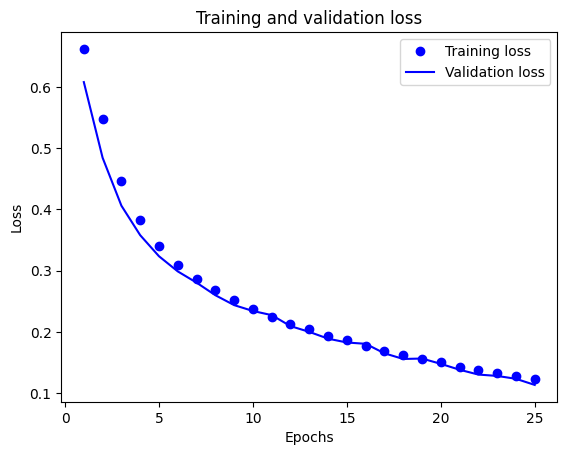

In [63]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # bo is blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b for blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

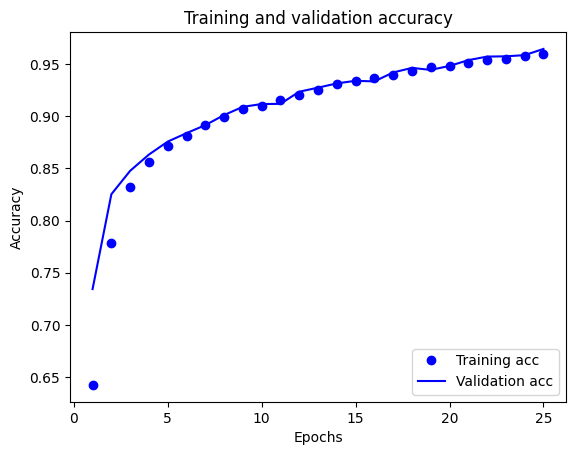

In [64]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [65]:
max(val_acc)

0.9645500183105469

### Export the model

In [66]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss = losses.BinaryCrossentropy(from_logits=False), optimizer = 'adam', metrics = ['accuracy']
)

metrics = export_model.evaluate(raw_test_ds, return_dict = True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5056 - loss: 0.5770
{'accuracy': 0.504360020160675, 'loss': 0.5773574709892273}


### Inference on new model

In [67]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[0.59390587],
       [0.542157  ],
       [0.52603656]], dtype=float32)

In [77]:
# export_model.save('text_classification.h5') or 
export_model.save('text_classification.keras')